### Generate weights from NN training

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import scipy
from torchvision import transforms


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                ])

In [3]:
mnist_dev = torchvision.datasets.MNIST("./data", train=True, download=True, transform = transform)
mnist_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform = transform)

In [1]:
len(mnist_dev)

NameError: name 'mnist_dev' is not defined

In [5]:
x_dev = mnist_dev.data / 255.0
y_dev = mnist_dev.targets

torch.Size([60000, 28, 28])
torch.Size([60000])


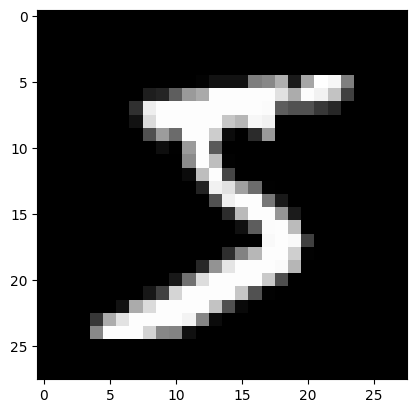

In [6]:
print(x_dev.shape)
print(y_dev.shape)

plt.imshow(x_dev[0], cmap="gray")

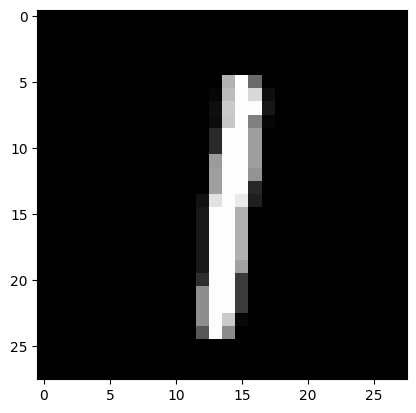

In [7]:
plt.imshow(x_dev[40], cmap="gray")

In [8]:
ntrain = 50000
x_train, y_train = x_dev[:ntrain].flatten(1), y_dev[:ntrain]
x_val, y_val = x_dev[ntrain:].flatten(1), y_dev[ntrain:]

In [9]:
x_dev[:ntrain].shape, x_train.shape

(torch.Size([50000, 28, 28]), torch.Size([50000, 784]))

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
class Net(nn.Module):
    def __init__(self, activation=nn.ReLU(),
                 input_size=1*28*28, hidden_size=5, classes=10):
        
        super(Net, self).__init__()
        self.input_size = input_size

        # Here we initialize our activation and set up our two linear layers
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, classes)

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return x

    def get_net_params(self):
        param_list = np.array([])
        for params in self.parameters():    
            param_list = np.concatenate((param_list, params.cpu().detach().numpy().flatten()))
        return param_list

In [12]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(x_train, y_train)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [13]:
train_set.tensors[0].shape, train_set.tensors[1].shape

(torch.Size([50000, 784]), torch.Size([50000]))

In [14]:
def sample_nn_run(seed):
    print("seed: ", seed)

    torch.manual_seed(seed)
    
    net = Net()
    # Always remember to move the network to the GPU/CPU depending on device
    net = net.to(device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    print("Shapes of the Parameter Matrix:")
    for parameter in net.parameters():
            print(parameter.shape)

    print("weight init shape: ", net.get_net_params().shape)
    print("weight init mean: ", net.get_net_params().mean())
    
    train_loss_history = [] # loss
    train_acc_history = [] # accuracy

    weights = [net.get_net_params()]
    
    for epoch in range(14):

        running_loss = 0.0
        correct = 0.0
        total = 0

        # Iterating through the minibatches of the data

        for i, data in enumerate(train_loader, 0):
            # data is a tuple of (inputs, labels)
            X, y = data

            X = X.to(device)
            y = y.to(device)

            # Reset the parameter gradients  for the current  minibatch iteration 
            optimizer.zero_grad()


            y_pred = net(X)             # Perform a forward pass on the network with inputs
            loss = criterion(y_pred, y) # calculate the loss with the network predictions and ground Truth
            loss.backward()             # Perform a backward pass to calculate the gradients
            optimizer.step()            # Optimize the network parameters with calculated gradients
            
            # save weights
            weights.append(net.get_net_params())

            # Accumulate the loss and calculate the accuracy of predictions
            running_loss += loss.item()
            _, preds = torch.max(y_pred, 1) #convert output probabilities of each class to a singular class prediction
            correct += preds.eq(y).sum().item()
            total += y.size(0)

            # Print statistics to console
            if i % 200 == 99: # print every 100 mini-batches
                running_loss /= 100
                correct /= total
                print("[Epoch %d, Iteration %5d] loss: %.3f acc: %.2f %%" % (epoch+1, i+1, running_loss, 100*correct))
                train_loss_history.append(running_loss)
                train_acc_history.append(correct)
                running_loss = 0.0
                correct = 0.0
                total = 0
    return weights

In [15]:
w = sample_nn_run(12)

seed:  12
Shapes of the Parameter Matrix:
torch.Size([5, 784])
torch.Size([5])
torch.Size([10, 5])
torch.Size([10])
weight init shape:  (3985,)
weight init mean:  -0.0008846448942401927
[Epoch 1, Iteration   100] loss: 2.259 acc: 18.31 %
[Epoch 1, Iteration   300] loss: 4.104 acc: 26.62 %
[Epoch 1, Iteration   500] loss: 3.592 acc: 38.16 %
[Epoch 1, Iteration   700] loss: 3.063 acc: 53.34 %
[Epoch 2, Iteration   100] loss: 1.251 acc: 62.38 %
[Epoch 2, Iteration   300] loss: 2.245 acc: 66.88 %
[Epoch 2, Iteration   500] loss: 1.996 acc: 71.50 %
[Epoch 2, Iteration   700] loss: 1.767 acc: 74.50 %
[Epoch 3, Iteration   100] loss: 0.802 acc: 76.81 %
[Epoch 3, Iteration   300] loss: 1.525 acc: 77.63 %
[Epoch 3, Iteration   500] loss: 1.454 acc: 78.98 %
[Epoch 3, Iteration   700] loss: 1.387 acc: 79.96 %
[Epoch 4, Iteration   100] loss: 0.663 acc: 80.41 %
[Epoch 4, Iteration   300] loss: 1.280 acc: 81.07 %
[Epoch 4, Iteration   500] loss: 1.250 acc: 81.82 %
[Epoch 4, Iteration   700] loss: 1

In [16]:
np.save("w_nn.pkl", np.array(w))

In [17]:
w = np.load("w_nn.pkl.npy")

In [18]:
w

array([[-0.00245089, -0.01908809, -0.00337707, ..., -0.12924042,
         0.06457067, -0.21961719],
       [-0.00245089, -0.01908809, -0.00337707, ..., -0.12921284,
         0.06457364, -0.21962918],
       [-0.00245089, -0.01908809, -0.00337707, ..., -0.12919217,
         0.06454732, -0.2195435 ],
       ...,
       [-0.00245089, -0.01908809, -0.00337707, ...,  0.0998647 ,
        -0.71123451, -0.57188541],
       [-0.00245089, -0.01908809, -0.00337707, ...,  0.09991028,
        -0.71127719, -0.57191908],
       [-0.00245089, -0.01908809, -0.00337707, ...,  0.09994707,
        -0.71120745, -0.5718953 ]])

In [19]:
w.shape

(10949, 3985)

### apply EDMD

#### define thin plate radial basis functions

In [21]:
from scipy.spatial import distance
def rbf_thin_plate(centers, x):
    delta = 10**-3
    out = []
    for c in centers:
        out.append((distance.euclidean(c,x)**2) * np.log(distance.euclidean(c,x) + delta))
    
    return(np.array(out))

In [22]:
w.shape

(10949, 3985)

#### apply kmeans to get centers for radial basis fucntions

In [23]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(1000, verbose=1, init='k-means++', n_init=1, random_state=11)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 0.7012163863927537
Iteration 1, inertia 0.5803341179592924
Iteration 2, inertia 0.5694275083028179
Iteration 3, inertia 0.5652782995857207
Iteration 4, inertia 0.5631359872166697
Iteration 5, inertia 0.5621718435407812
Iteration 6, inertia 0.5617685178381118
Iteration 7, inertia 0.5614951060710942
Iteration 8, inertia 0.5613337804733923
Iteration 9, inertia 0.5612034111330667
Iteration 10, inertia 0.5610981933418245
Iteration 11, inertia 0.5610438527630491
Iteration 12, inertia 0.5610261887306315
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 0.7012163863927537
Iteration 1, inertia 0.5803341179592924
Iteration 2, inertia 0.5694275083028179
Iteration 3, inertia 0.5652782995857207
Iteration 4, inertia 0.5631359872166697
Iteration 5, inertia 0.5621718435407812
Iteration 6, inertia 0.5617685178381118
Iteration 7, inertia 0.5614951060710942
Iteration 8, inertia 0.5613337804733923
Iteration 9, inertia 0

array([[-0.00245089, -0.01908809, -0.00337707, ...,  0.08371205,
        -0.66721874, -0.56170395],
       [-0.00245089, -0.01908809, -0.00337707, ..., -0.2174736 ,
        -0.19114802, -0.42391739],
       [-0.00245089, -0.01908809, -0.00337707, ..., -0.14083285,
         0.04053799, -0.21788493],
       ...,
       [-0.00245089, -0.01908809, -0.00337707, ...,  0.01439518,
        -0.50714844, -0.52322989],
       [-0.00245089, -0.01908809, -0.00337707, ..., -0.08371365,
        -0.33660696, -0.4782168 ],
       [-0.00245089, -0.01908809, -0.00337707, ..., -0.1817136 ,
        -0.22424344, -0.43923692]])

In [24]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 0, w.T)
w_t_transformed.shape

(1000, 10949)

In [25]:
w_t_transformed = w_t_transformed.T

In [26]:
w_t_transformed.shape

(10949, 1000)

In [27]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(10949, 4985)

In [28]:
np.save("w_t_combined.pkl", w_t_combined)

In [3]:
w_t_combined = np.load("w_t_combined.pkl.npy")

In [5]:
from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis, TSCIdentity, TSCApplyLambdas, TSCFeaturePreprocess
from datafold.pcfold import GaussianKernel, TSCDataFrame

In [6]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(10949, 4985)

In [7]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 10949
(n_samples, n_features): (10949, 4985)
time interval (0, 10948)
Same time values: True


In [8]:

dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_rbf = EDMD(dict_steps=dict_step, include_id_state=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/Users/saksham/Documents/tum_lecture_notes/seminar/code/datafold/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(4985, 4985)) has not full rank (=259), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [9]:
edmd_rbf

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [10]:
edmd_rbf_values = edmd_rbf.predict(w_tsc.initial_states())

len_koopman_matrix = len(edmd_rbf.named_steps["dmd"].eigenvectors_right_)
print(f"shape of Koopman matrix: {len_koopman_matrix} x {len_koopman_matrix}")
#edmd_rbf.transform(tsc_data)

shape of Koopman matrix: 4985 x 4985


In [11]:
len_koopman_matrix = len(edmd_rbf.named_steps["dmd"].eigenvectors_right_)
len_koopman_matrix


4985

In [12]:
edmd_rbf_values.shape

(10949, 4985)

In [14]:
edmd_rbf_values[1001]

feature       1001
ID time           
0  0     -0.019088
   1     -0.019089
   2     -0.019089
   3     -0.019089
   4     -0.019089
...            ...
   10944 -0.019089
   10945 -0.019089
   10946 -0.019089
   10947 -0.019089
   10948 -0.019089

[10949 rows x 1 columns]

In [ ]:
edmd_rbf_values